**PARTE 3**

---
# **KNN**
---


In [ ]:
!pip install pyts

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import h5py

from google.colab import drive
from pyts.transformation import ShapeletTransform
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score, accuracy_score
from pyts.transformation import ROCKET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/ML/G6_Project2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#5. Models

-----
# **5.3 KNN**
-----

In [ ]:

class KNN:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def predict(self, X):
        y_pred = []
        for x in X:
            distances = np.array([self.euclidean_distance(x, x_train) for x_train in self.X_train])
            k_indices = distances.argsort()[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]


            label_weights = {}
            for i, index in enumerate(k_indices):
                label = self.y_train[index]
                weight = 1 / (distances[index] + 1e-5)
                if label in label_weights:
                    label_weights[label] += weight
                else:
                    label_weights[label] = weight

            most_common = max(label_weights, key=label_weights.get)
            y_pred.append(most_common)
        return np.array(y_pred)


##**Data**

**Esta función abre un archivos h5 y lee los datos etiquetados como 'x'. Si el archivo también contiene datos etiquetados como 'y', los lee opcionalmente. Luego, la función devuelve estos datos.**

In [ ]:
def readH5File(filename):
  with h5py.File(path + filename, 'r') as f:
    x = f['x'][:]
    if 'y' in f:
      y = f['y'][:]
      return x, y

In [ ]:
def confusionMatrix(y_pred, y_test, type_label):
  labels = ['no predisposition to alcoholism', 'predisposition to alcoholism']
  matrix = confusion_matrix(y_test, y_pred).astype('float')
  matrix = matrix / matrix.sum(axis=1)[:, np.newaxis]
  df_matrix = pd.DataFrame(matrix, index=labels, columns=labels)

  sns.heatmap(df_matrix, annot=True, cbar=False, cmap="Greens")
  plt.title("Confusion Matrix " + type_label)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.tight_layout()
  plt.show()

In [ ]:
def getMetrics(y_test, y_pred):
  targets = ['no predisposition to alcoholism', 'predisposition to alcoholism']

  precision = precision_score(y_test, y_pred, average=None)
  f1 = f1_score(y_test, y_pred, average=None)

  report = classification_report(y_test, y_pred, target_names=targets)
  print("My Model Metrics:")
  print(report)

  results = {}
  for i, name in enumerate(targets):
    results[name] = {
      "Precision": precision[i],
      "F1-Score": f1[i]
    }

  return results

#Main Program

##**Extracting features**

Normalizamos la data y realizamos tranformadas

In [ ]:
X, Y = readH5File('train.h5')
X_test = readH5File('test.h5')
X = X.squeeze(axis=1)
X_test = X_test.squeeze(axis=1)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_test_normalized = scaler.fit_transform(x_test)

### **Usamos ROCKET**




Para aplicar el análisis de ROCKET al conjunto de datos de EEG sobre la predisposición genética al alcoholismo, primero se debe preprocesar los datos y luego aplicar el transformador ROCKET para extraer las características relevantes.


In [ ]:
rocket = ROCKET()
rocket.fit(x_train_normalized)
x_train_transformed = rocket.transform(x_train_normalized)
x_test_transformed = rocket.transform(x_test_normalized)
rocket.fit(x_train_normalized)
x_train_transformed = rocket.transform(x_train_normalized)


Se entrenará un modelo de clasificación con las características extraídas y se evaluará su rendimiento.

In [ ]:
# Entrenar y predecir con KNN
knn = KNN()
knn.fit(x_train_transformed, y_train)

# Hacer predicciones con KNN
k = 5  # Número de vecinos
y_pred = np.array([knn.predict(x, k) for x in x_test_transformed])

##**Classification Metrics**

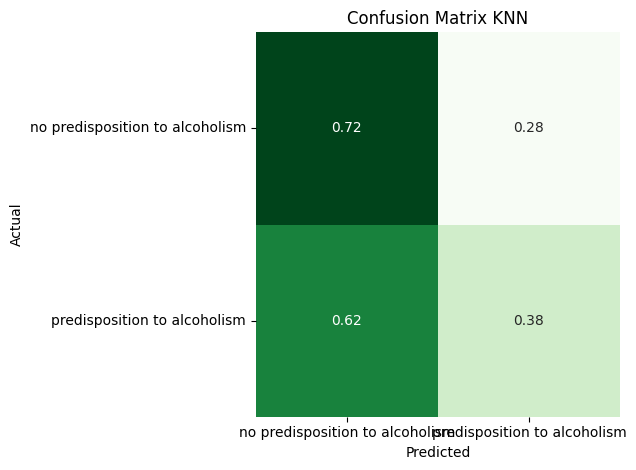

My Model Metrics:
                                 precision    recall  f1-score   support

no predisposition to alcoholism       0.77      0.72      0.74        46
   predisposition to alcoholism       0.32      0.38      0.34        16

                       accuracy                           0.63        62
                      macro avg       0.54      0.55      0.54        62
                   weighted avg       0.65      0.63      0.64        62

{'no predisposition to alcoholism': {'Precision': 0.7674418604651163, 'F1-Score': 0.7415730337078652}, 'predisposition to alcoholism': {'Precision': 0.3157894736842105, 'F1-Score': 0.34285714285714286}}


In [ ]:
confusionMatrix(y_pred, y_test, 'KNN')

metrics = getMetrics(y_test, y_pred)
print(metrics)